# CTH linear coefficents
In this notebook the coefficents for calculating the cloud top height are derived. This coefficents are the lapse_rate and offset, which are related to the CTH via the cloud top temperature (CTT) through the following relation:    
CTH = lapse_rate * CTT + offset  
In this notebook, the coefficents are determined by fitting each dropsonde's temperature profile (height vs. temperature) in a range between the sea surface to below the typical inversion height (2500m). This is a reasonable interval as the investigated clouds are capped by the inversion - meaning their cloud tops usually don't exeed the inversion height. This notebook is intended to be a tutorial for "CTH_calculate_coffs.py". 

In [1]:
import numpy as np 
import datetime 
import os 
import matplotlib.pyplot as plt
import glob
import time
from scipy.optimize import curve_fit
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import dask
import eurec4a
from intake import open_catalog
from scipy.stats import  linregress
import pandas as pd
from CTH_helper import *

In [2]:
all_flight_segments = eurec4a.get_flight_segments()
circles = [item for item in all_flight_segments['HALO']['HALO-0202']['segments'] if 'circle' in item['name'] and len(item['dropsondes']['GOOD']) > 5 ]

In [3]:
f = 'Flight_20200202a'
fnum = str(f[7:-1])
Y, M, D = int(fnum[0:4]), int(fnum[4:6]), int(fnum[6:])
f_format = f'HALO-{fnum[6:]}{fnum[4:6]}'

path = '/projekt_agmwend/data/EUREC4A/06_Flights/'+f+'/VELOX/VELOX_327kveL/'
cth_name = 'EUREC4A_HALO_VELOX_CTH_'+fnum+'_v0.3.nc'
tb_name = 'EUREC4A_HALO_VELOX_BT_Filter_01_'+fnum+'_v0.4.nc'
cm_name = 'EUREC4A_HALO_VELOX_cloudmask_'+fnum+'_v4.1.nc'
wl_name = '/projekt_agmwend/data/EUREC4A/06_Flights'+ f+'WALES/EUREC4A_HALO_WALES_cloudtop_'+fnum+'_V2.1.nc'
params_name = glob.glob(os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights',f,'BAHAMAS')+'/*.nc')[0]

def load_ts_high_res_unmasked(flight_path):
    path = os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights',flight_path ,'VELOX/VELOX_327kveL/10x10_Central_Pixel/')
    filename    =  flight_path[7:]+'_SOD_Center_10x10_Pixel_Envelope_Diff_Minus_Inhomo.txt'
    ts_central = np.loadtxt(path+filename, skiprows = 1).T

    return ts_central

xrtb = xr.open_dataset(path+tb_name)
xrparams = xr.open_dataset(params_name)
wl_path = glob.glob(os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights', f, 'WALES','*V2.1.nc'))
xrwl = xr.open_dataset(wl_path[0])

xrds = xr.open_dataset('/home/jomueller/EUREC4A_JOANNE_Dropsonde-RD41_Level_3_v2.0.0.nc')

select_flight = np.array([f_format in word.item() for word in xrds['sonde_id']])
ds_sel = xrds.sel(sonde_id = select_flight)
ds_sel['ta'] = ds_sel['ta'] - 273.15

sims = load_sims(f)
sim_datetime = [datetime.datetime(Y,M,D) + datetime.timedelta(seconds=sims[0,i,0]) for i in range(len(sims[0,:,0]))]
sim_np64 = np.array(sim_datetime, dtype=np.datetime64)
height = np.array([250, 500, 750, 1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])

xr_sim = xr.Dataset(
    data_vars=dict(
        dT=(["height", "time"], sims[:,:,1]),
    ),
    coords=dict(
        time=sim_np64,
        height=height,
    ),
    attrs=dict(description=f"VELOX{fnum} 10x10 NADIR PIXEL MEAN BT"))

sim_interp = xr_sim.interp(height=np.arange(1,13001),
    method="linear",
    kwargs={"fill_value": "extrapolate"},)

xrHALO = xr.Dataset(
    data_vars=dict(
        lat=(["time"], xrparams['IRS_LAT'].values),
        lon=(["time"], xrparams['IRS_LON'].values),
        alt=(["time"], xrparams['IRS_ALT'].values),
        roll=(["time"], xrparams['IRS_PHI'].values),
        pitch=(["time"], xrparams['IRS_THE'].values),
        hdg=(["time"], xrparams['IRS_HDG'].values),
        gs=(["time"], xrparams['IRS_GS'].values),

    ),
    coords=dict(

        time=xrparams['TIME'].values,
    ),
)

ts_hr_unmasked = load_ts_high_res_unmasked(f)
dt_datetime_unmasked = [datetime.datetime(Y,M,D) + datetime.timedelta(seconds=ts_hr_unmasked[0,i]) for i in range(len(ts_hr_unmasked[0,:]))]
dt_np64_unmasked = np.array(dt_datetime_unmasked, dtype=np.datetime64)

xr_ts_hr_unmasked = xr.Dataset(
    data_vars=dict(
        BT=(["time"], ts_hr_unmasked[1,:]),
        dT=(["time"], ts_hr_unmasked[2,:]),

    ),
    coords=dict(
        time=dt_np64_unmasked,
    ),
    attrs=dict(description=f"VELOX{fnum} 10x10 NADIR PIXEL MEAN BT"))

## Finding the right treshold

The cloud mask is constructed by taking the maximum of the nadir BT inside an intervall around each point. To denote a point as 'probably cloudy', the BT has to exceed the envelope by at least 0.5K, if it's exceeded by 2K, it is denoted as 'most likely clouded'. In the plot below, the distribution of nadir BT is shown with different tresholds. In the following the 0.5K treshold will be used. 

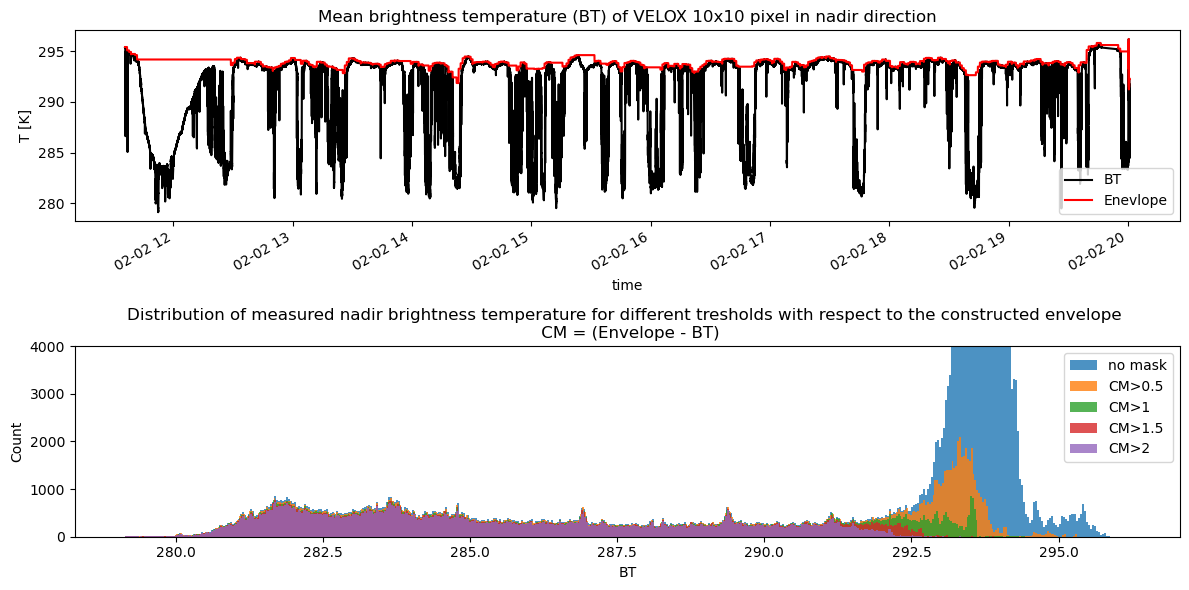

In [4]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(12, 6))

xr_ts_hr_unmasked.BT.plot(c='k', label='BT', ax=ax1)
xr_ts_hr_unmasked.dT.plot(c='r', label='Enevlope', ax=ax1)
ax1.set_ylabel('T [K]')
ax1.set_title('Mean brightness temperature (BT) of VELOX 10x10 pixel in nadir direction')
ax1.legend(loc='best')
xr_ts_hr_unmasked.BT.plot.hist(bins=500, alpha=0.8, label='no mask', ax=ax2)
for CM in [0.5, 1, 1.5, 2]:
    xr_ts_hr_unmasked.BT.where((xr_ts_hr_unmasked.dT - xr_ts_hr_unmasked.BT) > CM).plot.hist(bins=500, alpha=0.8, label=f'CM>{CM}', ax=ax2)
ax2.legend(loc='best')
ax2.set_ylim(0,4000)
ax2.set_ylabel('Count')
ax2.set_title('Distribution of measured nadir brightness temperature for different tresholds with respect to the constructed envelope \n CM = (Envelope - BT)')
plt.tight_layout()
plt.show()

## Atmospheric absorbtion

To account for the atmospheric absorbtion, simulation of the theoretically measured brightness temperature ($BT_{SIM}$) for different flying altitudes have been done. Then, the true BT is calculated via:  
    $BT = BT_{SIM}(CTH) - BT_{SIM}(HALO_{altitude})$  
Where CTH is WALES measured cloud top height and $HALO_{altitude}$ is the current flying altitude. If there isn't a measurement of the CTH availible, the mean CTH over 10 minutes is. used. In the plot below, the nadir BT timeseries and the derived corrected BT timeseries (accounted for atmospheric absorption) are plotted. 

([<matplotlib.lines.Line2D at 0x7f1dbb3a6af0>],
 [<matplotlib.lines.Line2D at 0x7f1dbb1af490>])

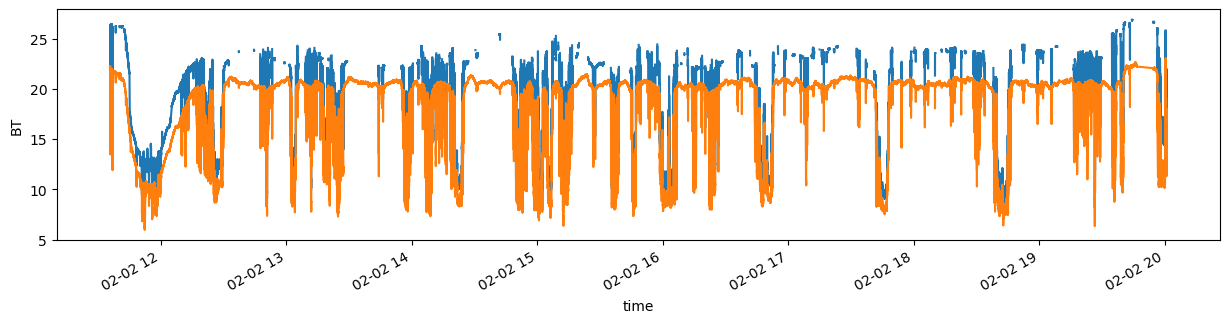

In [5]:
sim_temps = []
xrwl_interp   = xrwl['cloud_top'].interp_like(xr_sim)
xrHALO_interp = xrHALO['alt'].interp_like(xr_sim)
f_alt_mean = xrHALO_interp.mean()

for time in xr_sim.time:
    f_alt = xrHALO_interp.sel(time=time)
    if np.isnan(xrwl_interp.sel(time=time)):
        cth = xrwl_interp.sel(time=slice(time-np.timedelta64(5, 'm'), time+np.timedelta64(5, 'm'))).mean()
        if np.isnan(cth):
            cth = 1
    else:
        cth = xrwl_interp.sel(time=time)
    if np.isnan(xrHALO_interp.sel(time=time)):  
        f_alt = f_alt_mean

    T_correct = sim_interp.sel(time=time, height=int(cth)).dT.values - sim_interp.sel(time=time,height=int(f_alt)).dT.values
    sim_temps.append(T_correct)

xr_sim = xr_sim.assign(dict(T = (['time'], sim_temps)))
sim_hr_interp= xr_sim['T'].interp_like(xr_ts_hr_unmasked)
BT_masked = xr_ts_hr_unmasked.BT.where((xr_ts_hr_unmasked.dT - xr_ts_hr_unmasked.BT) > 0.5) - 273.15

xr_ts_hr_corr = xr.Dataset(
    data_vars=dict(
        BT=(["time"], BT_masked.values + sim_hr_interp.values ),
    ),
    coords=dict(
        time=dt_np64_unmasked,
    ),
    attrs=dict(description=f"VELOX{fnum} CORRECTED TS"))
fig, ax = plt.subplots(figsize = (15, 3))
xr_ts_hr_corr.BT.plot(ax=ax, label='BT'), (xr_ts_hr_unmasked.BT-273.15).plot(ax=ax, label='BT with atmos. corr.')

## Fitting the lapse rate 
Now BT is corrected by the atmospheric absorbtion, it's time to fit the dropsonde's temperature to its height profile. In the plot below, the basic idea is shown with the averaged dropsonde profiles. In the algorithm, the lapse rate and offset are derived for every dropsonde individually.

lapse rate = (-154.24 +/- 8.46) m/K 
 offset = (3920.14 +/- 176.84) m


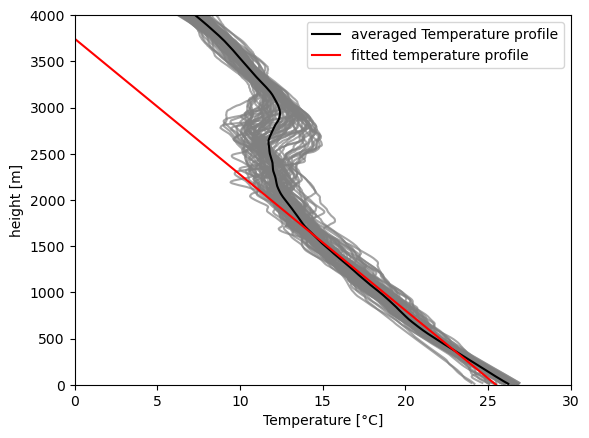

In [6]:
for i in range(ds_sel['ta'].shape[0]):
    ds_sel['ta'].isel(sonde_id=i).plot(c='grey', alpha=0.7, y='alt')
ds_sel['ta'].mean(dim={'sonde_id'}).plot(c='k', y='alt', label='averaged Temperature profile')
y=ds_sel['ta'].mean(dim={'sonde_id'})
mask = ~np.isnan(y) & ~np.isnan(y.alt)
slope, intercept, r, p, se = linregress(y[mask][:200], y.alt[mask][:200])
plt.plot(y, slope*y+intercept, label='fitted temperature profile', c='r')
plt.ylim(0,4000)
plt.xlim(0,30)
plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('height [m]')

S, I, R = [], [], []
for y in ds_sel['ta']:
    mask = ~np.isnan(y) & ~np.isnan(y.alt)
    slope, intercept, r, p, se = linregress(y[mask][0:220], y.alt[mask][0:220])
    S.append(slope)
    I.append(intercept)
    R.append(r**2)

xr_coff = xr.Dataset(
    data_vars=dict(
        lapse_rate = (['time'], S),
        offset = (['time'], I),
    ),
    coords=dict(
        time = ds_sel.launch_time.values,
    )
)
print(f'lapse rate = ({slope:.2f} +/- {np.array(S).std():.2f}) m/K \n offset = ({intercept:.2f} +/- {np.array(I).std():.2f}) m')

xr_coff_interp = xr_coff.interp_like(xr_ts_hr_unmasked)


## Looking at the results

In the following plot panel, the steps of adjusting the nadir CTH timeseries is shown. At first (left), the plain VELOX CTH results are plotted against the WALES CTH, where more yellow color mean more correlation. In the left middle panel, the VELOX CTH is corrected by the difference between WALES and VELOX (delta = CTH_VELOX -CTH_WALES), therefore the distributions match perfectly. Correcting the offset about an arbritray value seems to be the smarter option than varying the lapse rate as the lapse rate is a real physical variable. In the right middle panel VELOX CTH gets corrected by the 10 minute averaged of delta. The resulting 2d histogram shows a equal distribution around the 45° line. In the right panel, the CTH corrected by the averaged delta is again averaged over time and plotted against the 10 minute average of WALES CTH.  

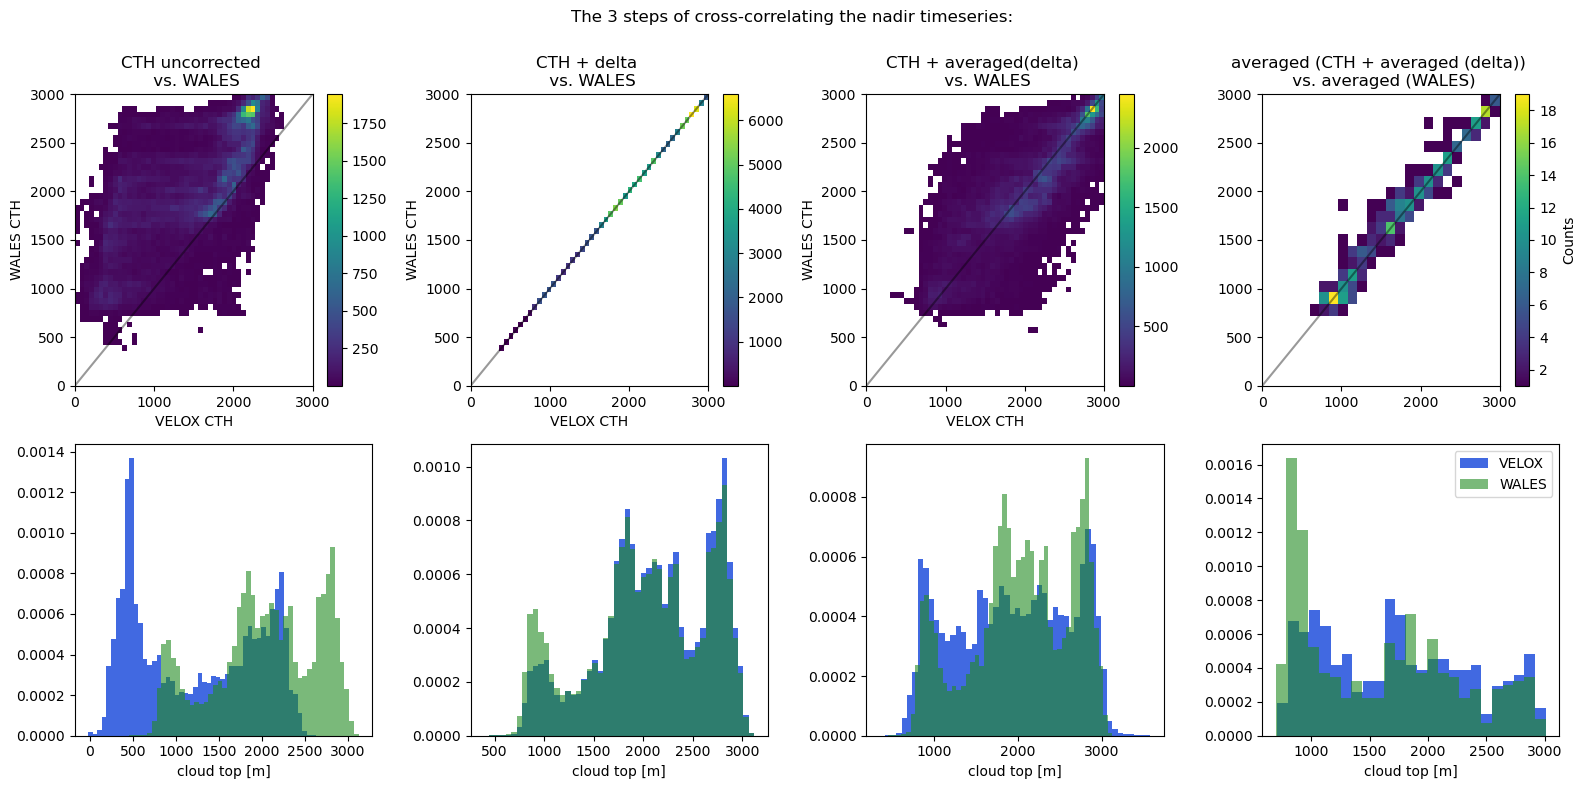

In [7]:
def height(brightness_temperature, lapse_rate, offset):
    return lapse_rate * brightness_temperature + offset

H = height(xr_ts_hr_corr['BT'], xr_coff_interp['lapse_rate'], xr_coff_interp['offset'])


wales = xrwl['cloud_top'].interp_like(xr_ts_hr_unmasked)
delta = H - xrwl['cloud_top'].interp_like(xr_ts_hr_unmasked)
off_coarsed = (xr_coff_interp['offset'] - delta).coarsen(time=600, boundary='trim').mean().interp_like(xr_ts_hr_unmasked)


H_corrected = height(xr_ts_hr_corr['BT'],xr_coff_interp['lapse_rate'], xr_coff_interp['offset'] - delta)
H_coarsed   = height(xr_ts_hr_corr['BT'],xr_coff_interp['lapse_rate'], off_coarsed)
H_averaged  = H_coarsed.coarsen(time=600, boundary='trim').mean()
WALES_averaged = wales.coarsen(time=600, boundary='trim').mean()

fig, ax = plt.subplots(2,4, figsize=(16,8))
titles = ['CTH uncorrected \n vs. WALES', 'CTH + delta \n vs. WALES', 'CTH + averaged(delta) \n vs. WALES']

for i, h in enumerate([H, H_corrected, H_coarsed]):
    ax[0,i].plot([0,3000], [0,3000], c='k', alpha=0.4)
    im = ax[0,i].hist2d(h, wales, bins=50,  cmin=1, range=((0,3000), (0,3000)))
    h.plot.hist(bins=50, density = 1, ax=ax[1,i], label='VELOX', color='royalblue')
    wales.plot.hist(bins=50, density = 1, alpha = 0.6, ax=ax[1,i], label='WALES', color='forestgreen')
    ax[0,i].set_title(titles[i])
    ax[0,i].set_xlabel('VELOX CTH')
    ax[0,i].set_ylabel('WALES CTH')
    fig.colorbar(im[3], ax=ax[0,i])
       
ax[0,3].plot([0,3000], [0,3000], c='k', alpha=0.4)
im = ax[0,3].hist2d(H_averaged, WALES_averaged, bins=25, cmin=1, range=((0,3000), (0,3000)))
fig.colorbar(im[3], ax=ax[0,3], label='Counts')
ax[0,3].set_title('averaged (CTH + averaged (delta)) \n vs. averaged (WALES)')
H_averaged.plot.hist(bins=25, density = 1, ax=ax[1,3],label='VELOX', color='royalblue')
WALES_averaged.plot.hist(bins=25, density = 1, ax=ax[1,3], alpha=0.6, label='WALES', color='forestgreen')
ax[1,3].legend(loc='best')
plt.suptitle('The 3 steps of cross-correlating the nadir timeseries: \n ')
plt.tight_layout()
plt.show()

To illustrate the quality of the derived nadir CTH, the timeseries is shown for each of the 6 circles. 

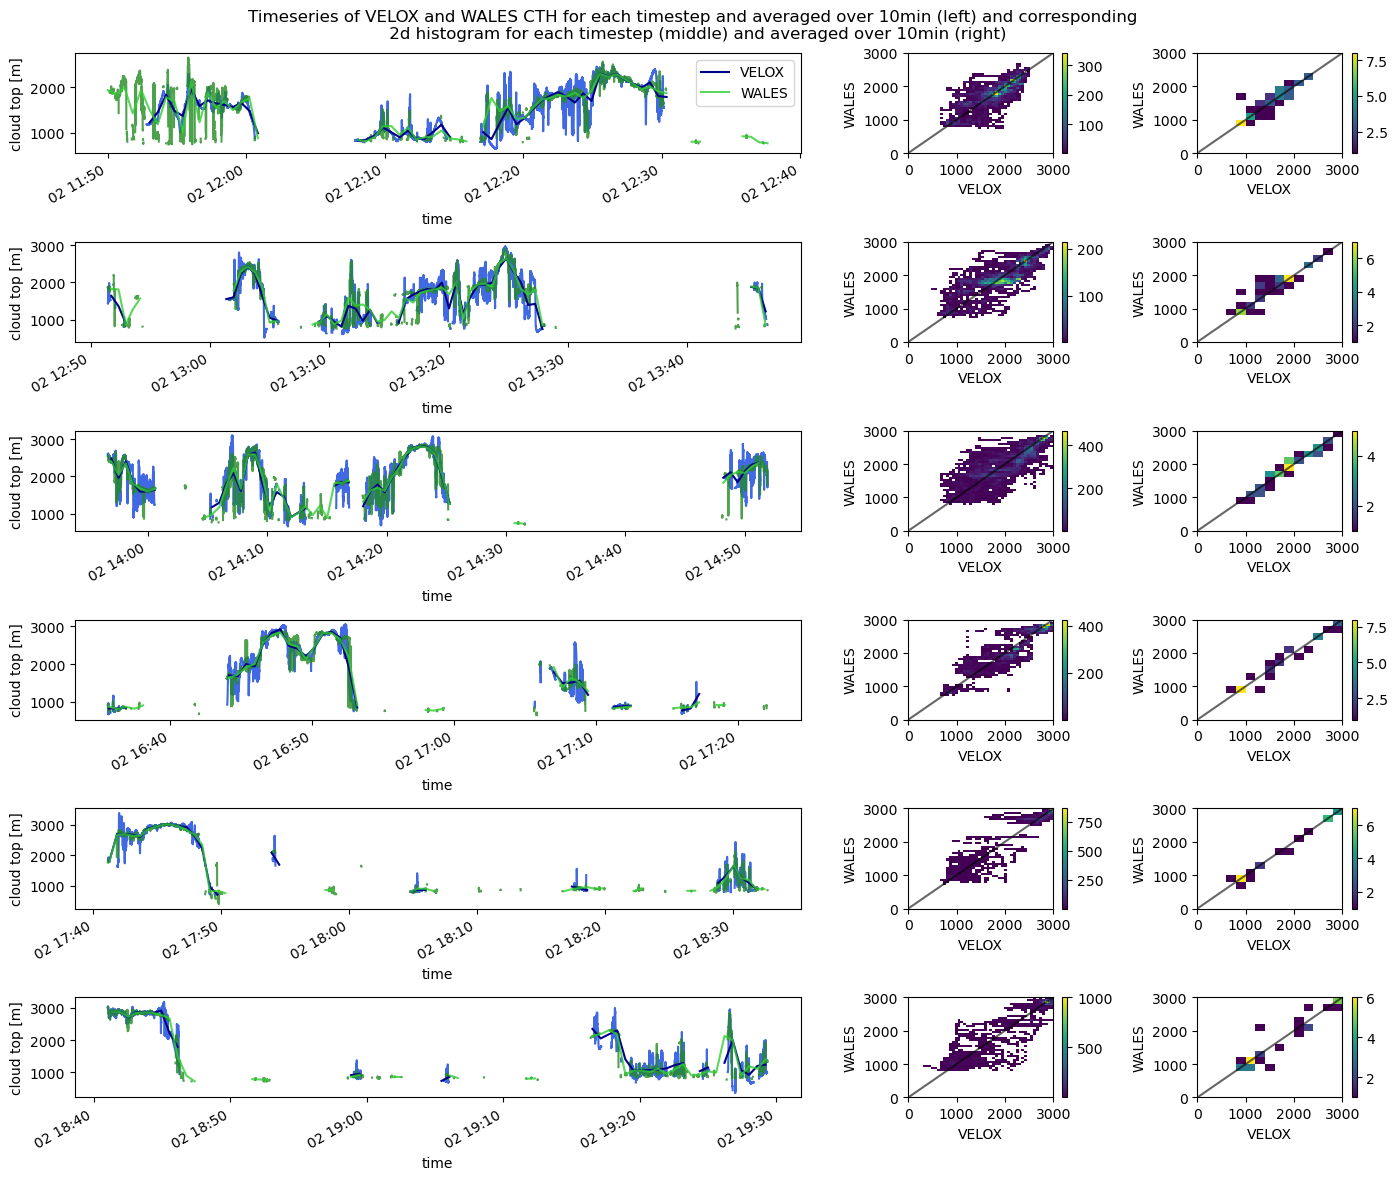

In [8]:
fig, axes = plt.subplots(6, 3, figsize = (14, 12), gridspec_kw={'width_ratios': [4, 1, 1]})

for i, ax in enumerate(axes):

    H_coarsed.sel(time=slice(circles[i]['start'], circles[i]['end'])).plot(ax= ax[0], color='royalblue')
    wales.sel(time=slice(circles[i]['start'], circles[i]['end'])).plot(ax=ax[0], color='forestgreen', alpha=0.8)
    H_coarsed.sel(time=slice(circles[i]['start'], circles[i]['end'])).coarsen(time=600, boundary='trim').mean().plot(color='darkblue', ax=ax[0], label='VELOX')
    wales.sel(time=slice(circles[i]['start'], circles[i]['end'])).coarsen(time=600, boundary='trim').mean().plot(color='limegreen', ax=ax[0], alpha=0.8, label='WALES')
    H_VELOX_circle = H_coarsed.sel(time=slice(circles[i]['start'], circles[i]['end']))
    H_WALES_circle = xrwl['cloud_top'].interp_like(H).sel(time=slice(circles[i]['start'], circles[i]['end']))
    ax[1].plot([0,3000], [0,3000], 'k-', alpha=0.6)
    im = ax[1].hist2d(H_VELOX_circle.values , H_WALES_circle.values, bins=50, range=[(0,3000), (0,3000)], cmin=1)
    fig.colorbar(im[3], ax=ax[1])
    ax[2].plot([0,3000], [0,3000], 'k-', alpha=0.6)
    im = ax[2].hist2d(H_VELOX_circle.coarsen(time=600, boundary='trim').mean().values , H_WALES_circle.coarsen(time=600, boundary='trim').mean().values, bins=15, range=[(0,3000), (0,3000)], cmin=1)
    fig.colorbar(im[3], ax=ax[2])
    ax[1].set_xlabel('VELOX')
    ax[2].set_xlabel('VELOX')
    ax[1].set_ylabel('WALES')
    ax[2].set_ylabel('WALES')

axes[0][0].legend()
plt.suptitle('Timeseries of VELOX and WALES CTH for each timestep and averaged over 10min (left) and corresponding \n 2d histogram for each timestep (middle) and averaged over 10min (right)')
plt.tight_layout()


In [9]:
i = 2
mean_ta = ds_sel.sel(sonde_id=circles[i]['dropsondes']['GOOD']).ta.mean(dim='sonde_id')
start, end = circles[i]['start'], circles[i]['end']
idx_slice = slice(start, end)

mask = ~np.isnan(mean_ta) & ~np.isnan(mean_ta.alt)
slope, intercept, r, p, se = linregress(mean_ta[mask][0:300], mean_ta.alt[mask][0:300])

H = slope * (xr_ts_hr_unmasked.interp_like(xrtb).sel(time=idx_slice).BT -273.15) + intercept
W = xrwl.cloud_top.interp_like(xrtb).sel(time=idx_slice)

x = xrwl.cloud_top.sel(time=idx_slice)#.plot(linestyle='', marker='.', markersize=0.3)
y = H.interp_like(x)#.plot(linestyle='', marker='.', markersize=0.3)
# plt.hist2d(y, x, range=((0,3000),(0,3000)), bins= 100, cmin=1)
# plt.plot([0,3000],[0,3000], 'k--')
# plt.figure()
# H.plot(linestyle='', marker='.', markersize=0.3)
# x.plot(linestyle='', marker='.', markersize=0.3)
# plt.show()

### Preview: 

In [10]:
alpha, beta = 35.5, 28.7


def pixel_to_meter(pitch, roll, height, alpha=alpha, beta=beta):

    pitch = np.radians(pitch)
    roll = np.radians(roll)
    alpha = np.radians(alpha)
    beta = np.radians(beta)

    xlen = (np.tan(alpha/2 + roll) + np.tan(alpha/2 - roll)) * height
    ylen = (np.tan(beta/2 + pitch) + np.tan(beta/2 - pitch)) * height

    return xlen, ylen

In [11]:
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 20,
                     'axes.labelsize': 18,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'axes.grid' : True})

In [12]:
cth_path = '/projekt_agmwend/data/EUREC4A/06_Flights/Flight_20200202a/VELOX/VELOX_327kveL/CTH/EUREC4A_HALO_VELOX_CTH_Flight_20200202a_C2.nc'
xrcth = xr.open_dataset(cth_path)
xrcm = xr.open_dataset(path + cm_name)
xrcth

<xarray.Dataset>
Dimensions:  (time: 3252, x: 640, y: 512)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02T12:51:26 ... 2020-02-02T13:46:57
Dimensions without coordinates: x, y
Data variables:
    CTH      (time, x, y) int32 ...
    CF_max   (time) float64 ...
Attributes:
    title:       Two-dimensional cloud-top height with 1 Hz temporal resoluti...
    version:     Version v0.31 from 2022-02-06
    comment_1:   cloud-height is derived from combination of 7.70 -12.00 micr...
    variable:    CTH
    author:      Michael Schäfer, André Ehrlich, Anna Luebke, Jakob Thoböll, ...
    history:     2022-06-21 : updated dataset attributes, 2022-08-17 : improv...
    created_on:  2022-02-06

/tmp/user/1431/ipykernel_729320/406601373.py:65: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(fig1, cax=cax, orientation='vertical', label='BT [°C]')
/tmp/user/1431/ipykernel_729320/406601373.py:70: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb2 = fig.colorbar(fig2, cax=cax2, orientation='vertical', label='CTH [m]')


<Figure size 640x480 with 0 Axes>

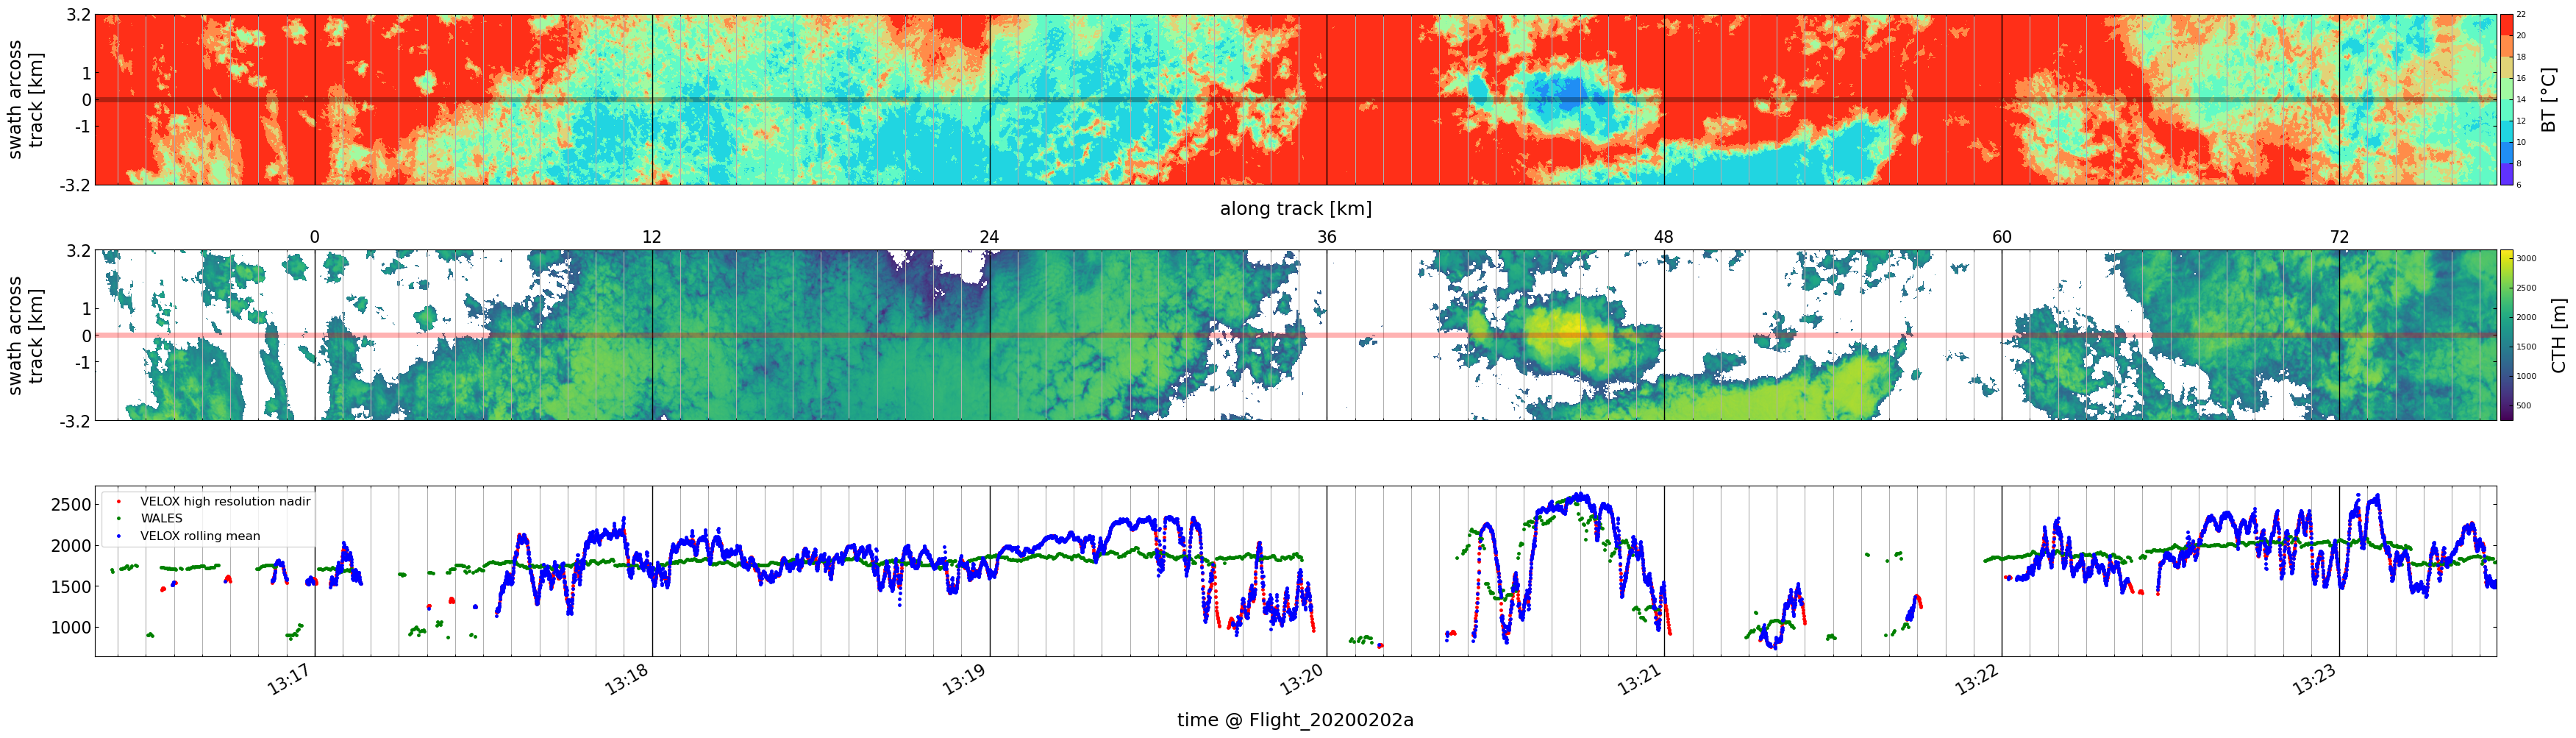

<Figure size 640x480 with 0 Axes>

In [64]:
tt = xrtb.time.values
tb = xrtb.BT_2D.values
cm = xrcm.cloud_mask.values
cth = xrcth.CTH.values
ranges = [np.arange(np.where(xrtb.time==xrtb.time.sel(time=circles[i]['start'], method='nearest'))[0], np.where(xrtb.time==xrtb.time.sel(time=circles[i]['end'], method='nearest'))[0]) for i in range(len(circles))]
rg = ranges[1]

view_start, view_stop = 40000, 50000

pys = np.round(pixel_to_meter(xrHALO['pitch'], xrHALO['roll'], xrHALO['alt'])[1] / 512)
gs  = np.round(xrHALO['gs'])
dys = np.array(np.round(gs / pys, 0), dtype='int32')
time = [[tt[i] for j in range(dys[i])] for i in rg]
lt = [item for sublist in time for item in sublist]

import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
x_lims = mdates.date2num([lt[view_start], lt[view_stop]])

arrs = [tb[i,:,256: 256 + dys[i]] for i in rg]
cths = [cth[i,::-1,256: 256 + dys[rg[i]]] for i in range(len(rg))]
#mask = [cm[400: 400 + dys[i], :, i] for i in rg]
im = np.concatenate(arrs, axis=1)
im2 = np.concatenate(cths, axis=1, dtype=np.float32)

im2[im2 == 0] = im2[im2 ==0] * np.nan

interp_time = [pd.date_range(time[i][0], time[i+1][0], periods=len(time[i])).values for i in range(len(time) -1)]
it = [item for sublist in interp_time for item in sublist]


cth_stripe = xr.Dataset(
    data_vars=dict(
        CTH = (['swath', 'time'], im2[:,:len(it)]),
        BT  = (['swath', 'time'], im[:,:len(it)])),
    coords=dict(time = it, swath = np.arange(0, 640),
    ),
)




y_lims = [0, 640]

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(35,10), sharex=True)

fig1 = ax1.contourf(im[:,view_start:view_stop], extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
        cmap='rainbow')

        
fig2 = ax2.imshow(im2[:,view_start:view_stop], extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto', vmin = 250)
ax1.xaxis_date()

dif =  H_coarsed.interp_like(cth_stripe) - cth_stripe.CTH.isel(swath=slice(315, 325)).mean(dim={'swath'}).rolling(time=1, center=True).mean()
H_coarsed.sel(time=slice(lt[view_start], lt[view_stop])).plot(linestyle='', marker='.', markersize=5, c='r', ax=ax3, label='VELOX high resolution nadir')
xrwl.cloud_top.sel(time=slice(lt[view_start], lt[view_stop])).plot(linestyle='', marker='.', markersize=5, c='g', ax=ax3, label='WALES')
#xrcth.CTH.isel(x=slice(315,325),y=slice(251,261)).sel(time=slice(lt[view_start], lt[view_stop])).mean(dim={'x', 'y'}).plot(linestyle='', marker='.', markersize=5, c='b', ax=ax3, label='VELOX 2D')
(cth_stripe.CTH.sel(time=slice(lt[view_start], lt[view_stop])).isel(swath=slice(315, 325)).mean(dim={'swath'}).rolling(time=10, center=True).mean() +dif.sel(time=slice(lt[view_start], lt[view_stop]))).plot(linestyle='', marker='.', markersize=5, c='b', label='VELOX rolling mean')


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='0.5%', pad=0.05)
ax1.tick_params(axis='both', which='minor', labelsize=8)
cb = fig.colorbar(fig1, cax=cax, orientation='vertical', label='BT [°C]')
cb.ax.tick_params(labelsize=8)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='0.5%', pad=0.05)
ax2.tick_params(axis='both', which='minor', labelsize=8)
cb2 = fig.colorbar(fig2, cax=cax2, orientation='vertical', label='CTH [m]')
cb2.ax.tick_params(labelsize=8)
divider = make_axes_locatable(ax3)
cax2 = divider.append_axes('right', size='0.5%', pad=0.05)
cax2.set_visible(False)
ax1.axhline(320, c='k', linewidth=5, alpha=.3)
ax2.axhline(320, c='r', linewidth=5, alpha=.3)
ax1.set_ylabel('swath arcoss\ntrack [km]')
ax2.set_ylabel('swath across\ntrack [km]')
ax3.legend(loc='upper left')
ax2.set_yticks([0, 220, 320, 420, 640])
ax2.set_yticklabels([-3.2, -1, 0, 1, 3.2])
ax1.set_yticks([0, 220, 320, 420, 640])
ax1.set_yticklabels([-3.2, -1, 0, 1, 3.2])
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%H:%M")
ax1.xaxis.set_major_formatter(date_form)
ax3.set_xlabel(f'time @ {f}')
ax3.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 5)))
ax1.grid(which='minor')
ax2.grid(which='minor')
ax3.grid(which='minor')


ax1.grid(which='major', lw=1, c='k')
ax2.grid(which='major', lw=1, c='k')
ax3.grid(which='major', lw=1, c='k')

ax1.grid(which='both',visible=None, axis='y')
ax2.grid(which='both',visible=None, axis='y')
ax3.grid(which='both',visible=None, axis='y')

# for ax in (ax1, ax2):
#         ax4 = ax.twiny()
#         ax4.set_xticks(ax.get_xticks())
#         #ax4.set_xbound(ax.get_xbound())

ax22 = ax2.secondary_xaxis('top')
ax22.set_xlabel('along track [km]')
ax22.set_xticks(ax2.get_xticks())
ax22.set_xticklabels([0, 12, 24, 36, 48, 60, 72])

plt.tight_layout(pad=0.5)
plt.figure()



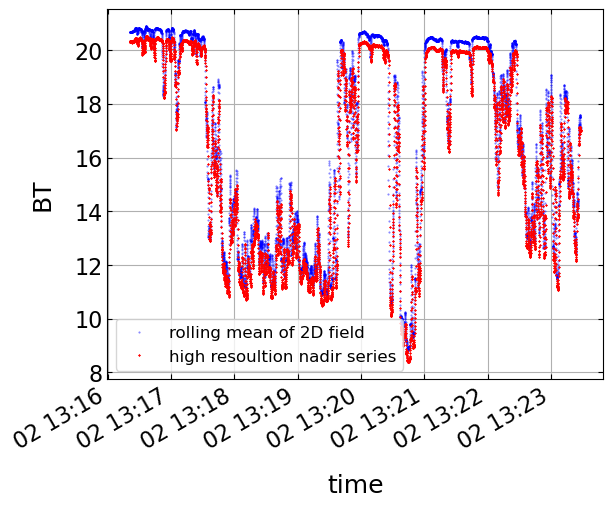

In [21]:
cth_stripe.BT.sel(time=slice(lt[view_start], lt[view_stop])).isel(swath=slice(315, 325)).mean(dim={'swath'}).rolling(time=10, center=True).mean().plot(linestyle='', marker='.', markersize=1, c='b', label='rolling mean of 2D field', alpha=0.5)
(xr_ts_hr_unmasked.BT.sel(time=slice(lt[view_start], lt[view_stop])) - 273.15).plot(linestyle='', marker='x', markersize=1, c='r', label='high resoultion nadir series')
plt.legend()


In [ ]:
sup_array = []
for j in range(0, 500, 30):
    arrs = [tb[i,:,j: j + dys[i]] for i in ranges[2]]
    im = np.concatenate(arrs, axis=1)
    sup_array.append(np.pad(im, ((0,0), (j,640-j)), constant_values=np.nan))


In [ ]:
sarray= np.array(sup_array)
im_mean = np.mean(sarray, axis =0)